In [1]:
# Notre DIP
!git clone https://github.com/quentgar/deep_image_prior.git
!mv deep_image_prior/* ./

!git clone https://github.com/DmitryUlyanov/deep-image-prior
!mv deep-image-prior/* ./

Cloning into 'deep_image_prior'...
remote: Enumerating objects: 55, done.
remote: Counting objects: 100% (55/55), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 55 (delta 9), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (55/55), done.
Cloning into 'deep-image-prior'...
remote: Enumerating objects: 289, done.
remote: Total 289 (delta 0), reused 0 (delta 0), pack-reused 289
Receiving objects: 100% (289/289), 24.28 MiB | 31.88 MiB/s, done.
Resolving deltas: 100% (155/155), done.


In [2]:
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline

import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '1'

import numpy as np
from models.resnet import ResNet
from models.unet import UNet
from models.skip import skip
from src.hourglass_network import *
import torch
import torch.optim

from utils.inpainting_utils import *
from skimage.measure import compare_psnr

import time

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True
dtype = torch.cuda.FloatTensor

PLOT = True
imsize = -1
dim_div_by = 64

In [79]:
## Fig 6
#img_path  = 'data/inpainting/vase.png'
#mask_path = 'data/inpainting/vase_mask.png'

## Fig 8
img_path  = 'data/inpainting/library.png'
mask_path = 'data/inpainting/library_mask.png'

## Fig 7 (top)
# img_path  = 'data/inpainting/kate.png'
# mask_path = 'data/inpainting/kate_mask.png'

# Another text inpainting example
# img_path  = 'data/inpainting/peppers.png'
# mask_path = 'data/inpainting/peppers_mask.png'

NET_TYPE = 'skip_depth6' # one of skip_depth4|skip_depth2|UNET|ResNet

In [80]:
img_pil, img_np = get_image(img_path, imsize)
img_mask_pil, img_mask_np = get_image(mask_path, imsize)

In [81]:
img_mask_pil = crop_image(img_mask_pil, dim_div_by)
img_pil      = crop_image(img_pil,      dim_div_by)

img_np      = pil_to_np(img_pil)
img_mask_np = pil_to_np(img_mask_pil)

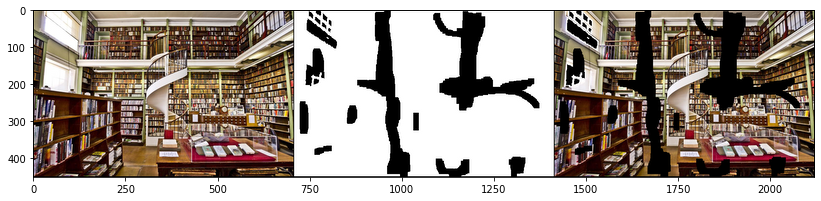

In [82]:
img_mask_var = np_to_torch(img_mask_np).type(dtype)

plot_image_grid([img_np, img_mask_np, img_mask_np*img_np], 3,11);

In [83]:
pad = 'reflection' # 'zero'
OPT_OVER = 'net'
OPTIMIZER = 'adam'

In [84]:
if 'vase.png' in img_path:
    INPUT = 'noise'
    input_depth = 2
    LR = 0.01 
    num_iter = 5001
    param_noise = False
    show_every = 50
    figsize = 5
    reg_noise_std = 0.03
    """
    net = build_hourglass(input_depth, output_depth=img_np.shape[0], 
               num_channels_down = [128]*5,
               num_channels_up =   [128]*5,
               num_channels_skip =    [0]*5,  
               filter_size_up = 3, filter_size_down = 3, 
               up_samp_mode='nearest', filter_skip_size=1).type(dtype)
    """
    net = skip(input_depth, img_np.shape[0], 
               num_channels_down = [128] * 5,
               num_channels_up   = [128] * 5,
               num_channels_skip = [0] * 5,  
               upsample_mode='nearest', filter_skip_size=1, filter_size_up=3, filter_size_down=3,
               need_sigmoid=True, need_bias=True, pad=pad, act_fun='LeakyReLU').type(dtype)
    
elif ('kate.png' in img_path) or ('peppers.png' in img_path):
    # Same params and net as in super-resolution and denoising
    INPUT = 'noise'
    input_depth = 32
    LR = 0.01 
    num_iter = 6001
    param_noise = False
    show_every = 50
    figsize = 5
    reg_noise_std = 0.03
    
    net = build_hourglass(input_depth, img_np.shape[0], 
               num_channels_down = [128] * 5,
               num_channels_up =   [128] * 5,
               num_channels_skip =    [128] * 5,  
               filter_size_up = 5, filter_size_down = 5, 
               up_samp_mode='nearest', filter_skip_size=1).type(dtype)
    """
    net = skip(input_depth, img_np.shape[0], 
               num_channels_down = [128] * 5,
               num_channels_up =   [128] * 5,
               num_channels_skip =    [128] * 5,  
               filter_size_up = 3, filter_size_down = 3, 
               upsample_mode='nearest', filter_skip_size=1,
               need_sigmoid=True, need_bias=True, pad=pad, act_fun='LeakyReLU').type(dtype)"""
    
elif 'library.png' in img_path:
    
    INPUT = 'noise'
    input_depth = 1
    
    num_iter = 3001
    show_every = 50
    figsize = 8
    reg_noise_std = 0.00
    param_noise = True
    
    if 'skip' in NET_TYPE:
        
        depth = int(NET_TYPE[-1])
        
        net = build_hourglass(input_depth, img_np.shape[0], 
               num_channels_down = [16, 32, 64, 128, 128, 128][:depth],
               num_channels_up =   [16, 32, 64, 128, 128, 128][:depth],
               num_channels_skip =    [0,0,0,0,0,0][:depth],  
               filter_size_up = 3, filter_size_down = 5, 
               up_samp_mode='nearest', filter_skip_size=1, num_scales=depth, need1x1_up=True).type(dtype)
        """
        net = skip(input_depth, img_np.shape[0], 
               num_channels_down = [16, 32, 64, 128, 128, 128][:depth],
               num_channels_up =   [16, 32, 64, 128, 128, 128][:depth],
               num_channels_skip =    [0, 0, 0, 0, 0, 0][:depth],  
               filter_size_up = 3,filter_size_down = 5,  filter_skip_size=1,
               upsample_mode='nearest', # downsample_mode='avg',
               need1x1_up=False,
               need_sigmoid=True, need_bias=True, pad=pad, act_fun='LeakyReLU').type(dtype)"""
        
        LR = 0.01 
        
    elif NET_TYPE == 'UNET':
        
        net = UNet(num_input_channels=input_depth, num_output_channels=3, 
                   feature_scale=8, more_layers=1, 
                   concat_x=False, upsample_mode='deconv', 
                   pad='zero', norm_layer=torch.nn.InstanceNorm2d, need_sigmoid=True, need_bias=True)
        
        LR = 0.001
        param_noise = False
        
    elif NET_TYPE == 'ResNet':
        
        net = ResNet(input_depth, img_np.shape[0], 8, 32, need_sigmoid=True, act_fun='LeakyReLU')
        
        LR = 0.001
        param_noise = False
        
    else:
        assert False
else:
    assert False

net = net.type(dtype)
net_input = get_noise(input_depth, INPUT, img_np.shape[1:]).type(dtype)

In [85]:
# Compute number of parameters
s  = sum(np.prod(list(p.size())) for p in net.parameters())
print ('Number of params: %d' % s)

# Loss
mse = torch.nn.MSELoss().type(dtype)

img_var = np_to_torch(img_np).type(dtype)
mask_var = np_to_torch(img_mask_np).type(dtype)

Number of params: 3052483


In [86]:
out=net(net_input)
net_input.shape

torch.Size([1, 1, 448, 704])

In [87]:
start_time = time.time()

i = 0
list_iter = []
list_psnr = []
list_loss = []
def closure():
    
    global i, list_iter, list_psnr, list_loss
    
    if param_noise:
        for n in [x for x in net.parameters() if len(x.size()) == 4]:
            n = n + n.detach().clone().normal_() * n.std() / 50
    
    net_input = net_input_saved
    if reg_noise_std > 0:
        net_input = net_input_saved + (noise.normal_() * reg_noise_std)
        
        
    out = net(net_input)
   
    total_loss = mse(out * mask_var, img_var * mask_var)
    total_loss.backward()
        
    if PLOT and i % show_every == 0:
        print ('Iteration %05d    Loss %f' % (i, total_loss.item()), '\r', end='')
        
        out_np = torch_to_np(out)
        list_iter.append(i)
        list_psnr.append(compare_psnr(img_np,out_np))
        list_loss.append(total_loss.item())
        plot_image_grid([np.clip(out_np, 0, 1)], factor=figsize, nrow=1)
        
    i += 1

    return total_loss

net_input_saved = net_input.detach().clone()
noise = net_input.detach().clone()

p = get_params(OPT_OVER, net, net_input)
optimize(OPTIMIZER, p, closure, LR, num_iter)

end_time = time.time()

Output hidden; open in https://colab.research.google.com to view.

In [89]:
total_time = end_time - start_time
minutes = int(total_time // 60)
secondes = int(total_time % 60)
print("--- %s minutes %s secondes ---" % (minutes, secondes))

--- 3 minutes 27 secondes ---


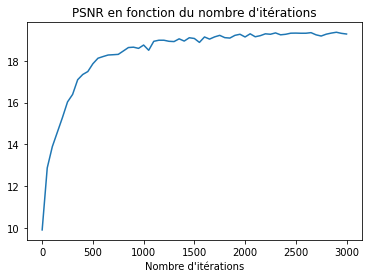

In [90]:
plt.figure()
plt.plot(list_iter,list_psnr,linestyle='-')
plt.title("PSNR en fonction du nombre d'itérations")
plt.xlabel("Nombre d'itérations")
plt.show()

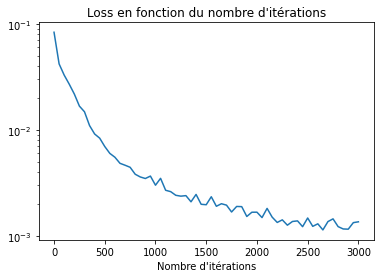

In [91]:
plt.figure()
plt.semilogy(list_iter,list_loss,linestyle='-')
plt.title("Loss en fonction du nombre d'itérations")
plt.xlabel("Nombre d'itérations")
plt.show()

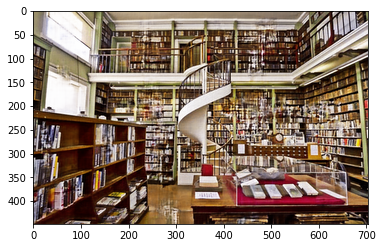

In [92]:
out_np = torch_to_np(net(net_input))
plot_image_grid([out_np], factor=5);

In [93]:
compare_psnr(img_np,out_np)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
  """Entry point for launching an IPython kernel.


19.313770353109355

In [94]:
list_iter[-1]

3000